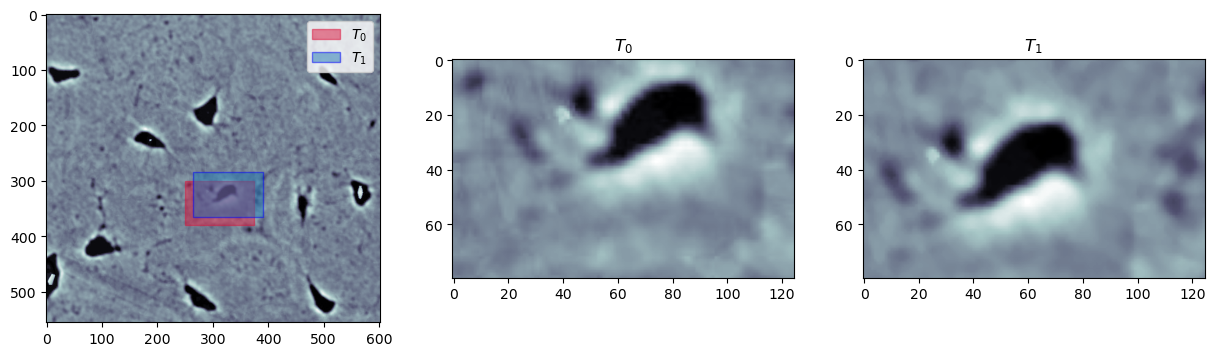

In [1]:
%matplotlib inline
import numpy as np
from skimage.filters import median
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.io import imread
%matplotlib inline
full_img = imread("figures/bonegfiltslice.png")[:,:,0:3].mean(axis=2)
dx,dy = -15,15
full_shift_img = median(
    np.roll(np.roll(full_img, dy, axis=0), dx, axis=1), footprint=np.ones((3, 3)))

roi = [300,250,380,375]
# def g_roi(x): return x[5:90, 150:275]
def g_roi(x): return x[roi[0]:roi[2],roi[1]:roi[3]]

bw_img = g_roi(full_img)
shift_img = g_roi(full_shift_img)

fig, (ax0,ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.imshow(full_img,cmap='bone')
r=Rectangle((roi[1],roi[0]),roi[3]-roi[1],roi[2]-roi[0],ec='crimson',fc='crimson',alpha=0.5,label=r"$T_0$")
ax0.add_patch(r)
r=Rectangle((roi[1]+dy,roi[0]+dx),roi[3]-roi[1],roi[2]-roi[0],ec='blue',alpha=0.5,label=r"$T_1$")
ax0.add_patch(r)
ax0.legend()
ax1.imshow(bw_img, cmap='bone')
ax1.set_title('$T_0$')
ax2.imshow(shift_img, cmap='bone')
ax2.set_title('$T_1$');

# SciKit Image

In [2]:
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle
from skimage.registration import optical_flow_ilk,optical_flow_tvl1
from skimage.transform import warp
reference_image, moving_image, disp = stereo_motorcycle()
# --- Convert the images to gray level: color is not supported.
reference_image = bw_img
moving_image    = shift_img 
[u,v]= optical_flow_tvl1(moving_image, reference_image)

In [3]:
nr, nc = bw_img.shape

row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')

image1_warp = warp(shift_img, np.array([row_coords + v, col_coords + u]),
                   mode='edge')

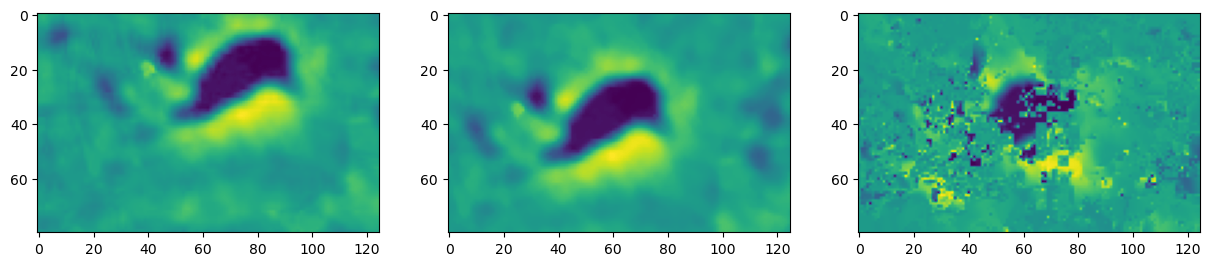

In [4]:
_, ax = plt.subplots(1,3,figsize=(15,4))

ax=ax.ravel()

for axs,img in zip(ax,[bw_img,shift_img,image1_warp]) :
    axs.imshow(img)

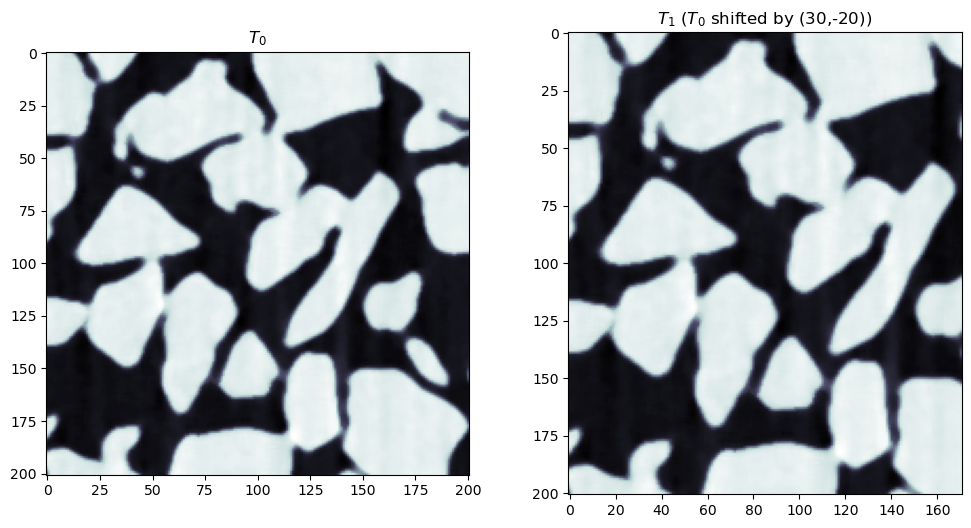

In [5]:
# Distance as feature 
bw_sand = plt.imread('data/sand.png').astype(float) # Some sand grains

shift_sand = bw_sand[:,:-30]
bw_sand = bw_sand[:shift_sand.shape[0],:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
ax1.imshow(bw_sand,cmap='bone'), ax1.set_title('$T_0$')
ax2.imshow(shift_sand, cmap='bone') , ax2.set_title('$T_1$ ($T_0$ shifted by (30,-20))');

In [6]:
from scipy.ndimage import distance_transform_edt
from skimage.filters import threshold_otsu


In [7]:
thresh_img = bw_sand > threshold_otsu(bw_sand)
dist_start_img = distance_transform_edt(thresh_img)
dist_shift_img = distance_transform_edt(shift_sand > threshold_otsu(bw_sand))

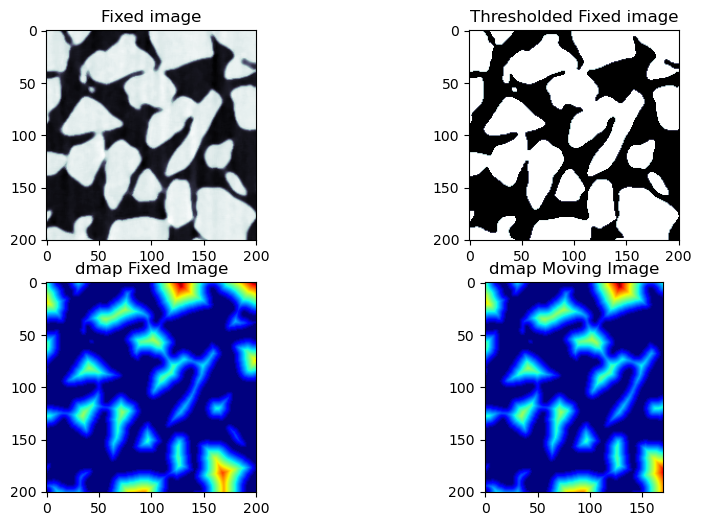

In [8]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(10,6))
ax1.imshow(bw_sand, cmap='bone')
ax1.set_title('Fixed image')
ax2.imshow(thresh_img, cmap='bone')
ax2.set_title('Thresholded Fixed image')
ax3.imshow(dist_start_img, cmap='jet')
ax3.set_title('dmap Fixed Image')
ax4.imshow(dist_shift_img, cmap='jet')
ax4.set_title('dmap Moving Image');

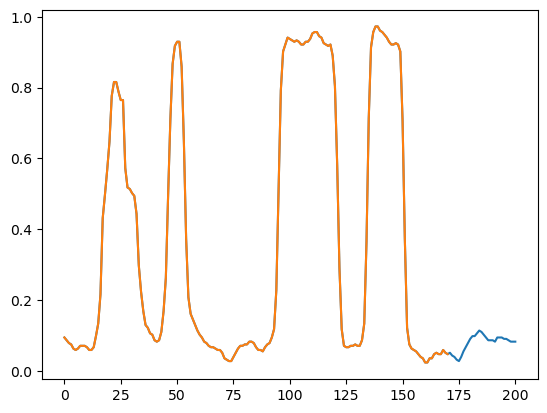

In [9]:
plt.plot(bw_sand[100])
plt.plot(shift_sand[100])

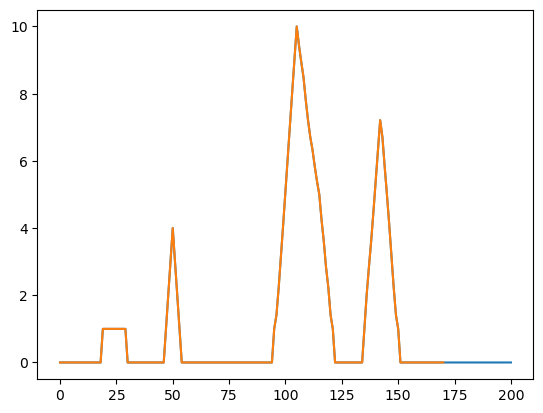

In [10]:
plt.plot(dist_start_img[100])
plt.plot(dist_shift_img[100])


# Tensorflow 2025

In [3]:
import tensorflow as tf
import numpy as np
from skimage.filters import median
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.io import imread
%matplotlib inline

full_img = imread("figures/bonegfiltslice.png")[:,:,0:3].mean(axis=2)
dx,dy = -15,15
full_shift_img = median(
    np.roll(np.roll(full_img, dy, axis=0), dx, axis=1), footprint=np.ones((3, 3)))

roi = [300,250,380,375]
# def g_roi(x): return x[5:90, 150:275]
def g_roi(x): return x[roi[0]:roi[2],roi[1]:roi[3]]

# Convert NumPy arrays to tf.Tensor
fixed_image = tf.convert_to_tensor(g_roi(full_img), dtype=tf.float32)
moving_image = tf.convert_to_tensor(g_roi(full_shift_img), dtype=tf.float32)

# If they are 2D (grayscale), add channel dimension → [H, W, 1]
if fixed_image.ndim == 2:
    fixed_image = tf.expand_dims(fixed_image, axis=-1)

if moving_image.ndim == 2:
    moving_image = tf.expand_dims(moving_image, axis=-1)


2025-04-15 16:10:15.436117: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-04-15 16:10:15.436162: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-15 16:10:15.436165: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1744726215.436179 33379633 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744726215.436206 33379633 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
import tensorflow as tf

def apply_affine_transform0(image, theta=0.0, tx=0.0, ty=0.0):
    """
    Apply 2D affine transform (rotation + translation) to a single image.
    
    Args:
        image: [H, W] or [H, W, C] tensor (grayscale or RGB).
        theta: Rotation angle in radians.
        tx, ty: Translation offsets (in pixels).
    Returns:
        Transformed image (same shape as input).
    """
    # Ensure image is 3D [H, W, C]
    if image.shape.ndims == 2:
        image = tf.expand_dims(image, axis=-1)  # [H, W] → [H, W, 1]
    
    if image.shape.ndims != 3:
        raise ValueError(f"Expected 2D or 3D image, got shape {image.shape}")

    # Add batch dimension → [1, H, W, C]
    image = tf.expand_dims(image, axis=0)
    
    height = tf.shape(image)[1]
    width = tf.shape(image)[2]

    # Create 8-parameter affine matrix
    cos_theta = tf.math.cos(theta)
    sin_theta = tf.math.sin(theta)

    # Projective transform format for TF (backward warp)
    transform = tf.stack([
        cos_theta, -sin_theta, tx,
        sin_theta,  cos_theta, ty,
        0.0, 0.0
    ])
    transform = tf.reshape(transform, [1, 8])  # batch of 1

    # Apply transform
    transformed = tf.raw_ops.ImageProjectiveTransformV3(
        images=image,
        transforms=transform,
        output_shape=tf.stack([height, width]),
        interpolation="BILINEAR",
        fill_mode="REFLECT",
        fill_value=0.0
    )

    # Remove batch dimension again → [H, W, C]
    transformed = tf.squeeze(transformed, axis=0)

    return transformed


In [5]:
import tensorflow as tf

def affine_transform_tf(image, theta=0.0, tx=0.0, ty=0.0, scale=1.0):
    """
    Differentiable affine transform (rotation + translation + uniform scale).
    
    Args:
        image: Tensor of shape [H, W, C] (grayscale or RGB).
        theta: Rotation angle in radians.
        tx, ty: Translation offsets (in pixels).
        scale: Uniform scaling factor.
    
    Returns:
        Transformed image of shape [H, W, C]
    """
    # Ensure input shape is [H, W, C]
    if image.ndim == 2:
        image = tf.expand_dims(image, -1)

    H, W, C = image.shape

    # Create a normalized grid [-1, 1] x [-1, 1]
    x = tf.linspace(-1.0, 1.0, W)
    y = tf.linspace(-1.0, 1.0, H)
    xx, yy = tf.meshgrid(x, y)
    grid = tf.stack([xx, yy, tf.ones_like(xx)], axis=-1)  # shape [H, W, 3]
    grid = tf.reshape(grid, [-1, 3])  # [H*W, 3]

    # Build affine transform matrix (rotation + scale + translation)
    cos_t = tf.cos(theta) * scale
    sin_t = tf.sin(theta) * scale
    tx_n = tx * 2.0 / tf.cast(W, tf.float32)  # normalize tx to [-1, 1]
    ty_n = ty * 2.0 / tf.cast(H, tf.float32)  # normalize ty to [-1, 1]

    affine = tf.stack([
        [cos_t, -sin_t, tx_n],
        [sin_t,  cos_t, ty_n]
    ])  # [2, 3]

    # Apply affine to grid
    coords = tf.matmul(grid, affine, transpose_b=True)  # [H*W, 2]
    coords = tf.reshape(coords, [H, W, 2])  # [H, W, 2]

    # Map from normalized [-1, 1] to image coordinates
    x = ((coords[..., 0] + 1.0) * 0.5) * tf.cast(W - 1, tf.float32)
    y = ((coords[..., 1] + 1.0) * 0.5) * tf.cast(H - 1, tf.float32)

    # Bilinear sampling
    x0 = tf.cast(tf.floor(x), tf.int32)
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), tf.int32)
    y1 = y0 + 1

    x0 = tf.clip_by_value(x0, 0, W - 1)
    x1 = tf.clip_by_value(x1, 0, W - 1)
    y0 = tf.clip_by_value(y0, 0, H - 1)
    y1 = tf.clip_by_value(y1, 0, H - 1)

    Ia = tf.gather_nd(image, tf.stack([y0, x0], axis=-1), batch_dims=0)
    Ib = tf.gather_nd(image, tf.stack([y1, x0], axis=-1), batch_dims=0)
    Ic = tf.gather_nd(image, tf.stack([y0, x1], axis=-1), batch_dims=0)
    Id = tf.gather_nd(image, tf.stack([y1, x1], axis=-1), batch_dims=0)

    wa = (1 - (x - tf.cast(x0, tf.float32))) * (1 - (y - tf.cast(y0, tf.float32)))
    wb = (1 - (x - tf.cast(x0, tf.float32))) * (y - tf.cast(y0, tf.float32))
    wc = (x - tf.cast(x0, tf.float32)) * (1 - (y - tf.cast(y0, tf.float32)))
    wd = (x - tf.cast(x0, tf.float32)) * (y - tf.cast(y0, tf.float32))

    wa = tf.expand_dims(wa, -1)
    wb = tf.expand_dims(wb, -1)
    wc = tf.expand_dims(wc, -1)
    wd = tf.expand_dims(wd, -1)

    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out


In [6]:
import tensorflow as tf

def affine_transform(fixed_img, moving_img, transform_params):
    # Define affine transform matrix
    theta = transform_params[0]
    tx    = transform_params[1]
    ty    = transform_params[2]
    
    transformed=affine_transform_tf(moving_image,theta=theta,tx=tx,ty=ty)
    return transformed


def similarity_loss(fixed_img, moving_img, transform_params):
    # Apply affine transform to moving image
    transformed_img = affine_transform(fixed_img, moving_img, transform_params)
    
    # Compute mean squared error between fixed and transformed moving images
    mse = tf.reduce_mean(tf.square(fixed_img - transformed_img))
    
    return mse

# Define the transform parameters as trainable variables
theta = tf.Variable(0.0, dtype=tf.float32, trainable=True)
tx    = tf.Variable(0.0, dtype=tf.float32, trainable=True)
ty    = tf.Variable(0.0, dtype=tf.float32, trainable=True)
transform_params = [theta, tx, ty]

# Define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.2)

# Define the training loop
N = 200
losses = []
frames = []
for i in range(N):
    with tf.GradientTape() as tape:
        tape.watch(transform_params)
        loss = similarity_loss(fixed_image, moving_image, transform_params)
        

    gradients = tape.gradient(loss, transform_params)

    optimizer.apply_gradients(zip(gradients, transform_params))
    
    losses.append(loss.numpy())
    frames.append(affine_transform(fixed_image, moving_image, transform_params))
    if i % 100 == 0:
        print(f'Loss at step {i}: {loss.numpy()}')

# Apply the learned transform to the moving image
registered_image = affine_transform(fixed_image, moving_image, transform_params)

Loss at step 0: 2486.349853515625
Loss at step 100: 62.435909271240234


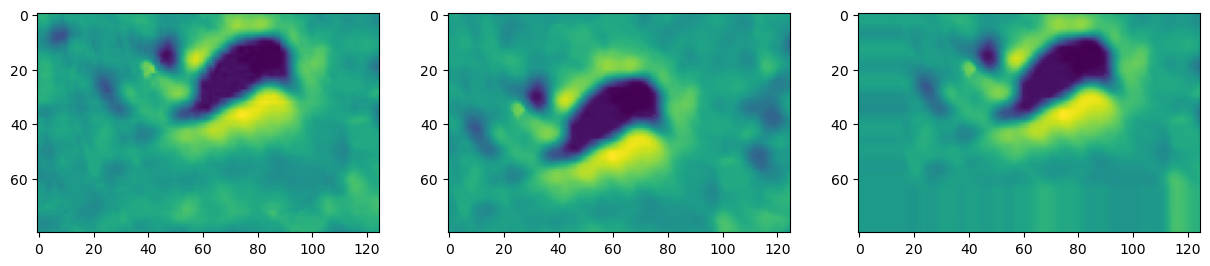

In [15]:
fig,ax=plt.subplots(1,3,figsize=(15,4))

ax[0].imshow(fixed_image)
ax[1].imshow(moving_image)
ax[2].imshow(registered_image)


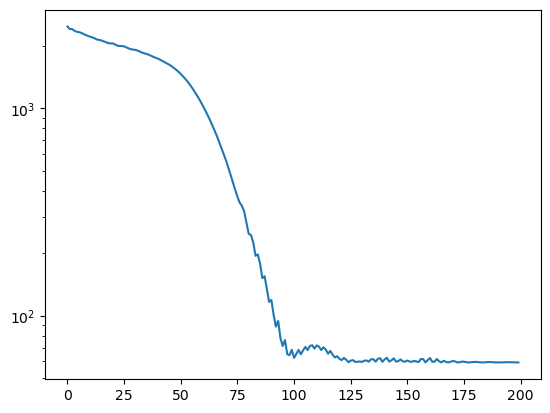

In [56]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import patches

fig, m_axs = plt.subplots(2, 3, figsize=(15, 7))
(ax1, ax2, ax5), (ax3, ax4, ax6) = m_axs

a4=ax4.imshow(frames[i]-fixed_image,cmap='RdBu',vmin=-150, vmax=150)
ax6.cla()
ax6.axis('off')
cbar=fig.colorbar(a4,ax=ax6)

    
def update_frame(i):

    for c_ax in m_axs.flatten():
        c_ax.cla()
#         c_ax.axis('off')
    

    ax1.imshow(fixed_image, cmap='bone')
    ax1.set_title('$T_0$')
    ax2.imshow(moving_image, cmap='bone')
    ax2.set_title('$T_1$')
    ax3.imshow(frames[i], cmap='bone')
    ax3.set_title('Output')
    
    ax5.plot(losses[:i])
    ax5.set_xlim([0,N])
    ax5.set_ylim([0,np.max(losses)])
    im=ax4.imshow(frames[i]-fixed_image,cmap='RdBu',vmin=-150, vmax=150)
    # Update the colorbar mappable
    a4.set_data(frames[i] - fixed_image)

anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=len(frames),
                          interval=1000,
                          repeat_delay=2000)#.to_html5_video()

anim_code.save('movies/test_reg.mp4', fps=10)
plt.close('all')

# Keras style

In [157]:
import tensorflow as tf

class AffineRegistrationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # Register trainable variables
        self.theta = tf.Variable(0.0, trainable=True, dtype=tf.float32, name='theta')
        self.tx    = tf.Variable(0.0, trainable=True, dtype=tf.float32, name='tx')
        self.ty    = tf.Variable(0.0, trainable=True, dtype=tf.float32, name='ty')

    def call(self, moving_img):
        # Apply affine transform
        return affine_transform_tf(moving_img, self.theta, self.tx, self.ty)

    def compute_loss(self, fixed_img, moving_img):
        transformed = self.call(moving_img)
        return tf.reduce_mean(tf.square(fixed_img - transformed))

#     def train_step(self, data):
#         fixed_img, moving_img = data
#         with tf.GradientTape() as tape:
#             loss = self.compute_loss(fixed_img, moving_img)
#         grads = tape.gradient(loss, self.trainable_variables)
#         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
#         return {"loss": loss}
    def train_step(self, data):
        print(len(data[0]))
        (fixed_img, moving_img) = data[0]
        print(fixed_img.shape)
        
        with tf.GradientTape() as tape:
            loss = self.compute_loss(fixed_img, moving_img)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": loss}



In [158]:
# Convert NumPy arrays to tf.Tensor
fixed_image = tf.convert_to_tensor(g_roi(full_img), dtype=tf.float32)
moving_image = tf.convert_to_tensor(g_roi(full_shift_img), dtype=tf.float32)

# If they are 2D (grayscale), add channel dimension → [H, W, 1]
if fixed_image.ndim == 2:
    fixed_image = tf.expand_dims(fixed_image, axis=-1)
    fixed_image = tf.expand_dims(fixed_image, axis=0)
    
if moving_image.ndim == 2:
    moving_image = tf.expand_dims(moving_image, axis=-1)
    moving_image = tf.expand_dims(moving_image, axis=0)


In [159]:
fixed_image.shape

TensorShape([1, 80, 125, 1])

In [160]:
model = AffineRegistrationModel()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.2))

# dataset = tf.data.Dataset.from_tensor_slices(((fixed, moving), None))
# dataset = dataset.batch(1)

# model.fit(dataset, epochs=200)


model.fit(x=(fixed, moving), y=None, epochs=200)

Epoch 1/200
2
(1, None, 80, 125, 1)


ValueError: too many values to unpack (expected 3)

In [63]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint("reg_model.keras", save_best_only=True)
]

model.fit((fixed, moving), epochs=300, callbacks=callbacks)


Epoch 1/300


ValueError: not enough values to unpack (expected 2, got 1)

# Use SSIM

## Old code

In [ ]:
%%file backport_ssim.py
from tensorflow.python.ops import array_ops, control_flow_ops, check_ops, math_ops, nn_ops, nn
from tensorflow.python.framework import constant_op, dtypes, ops

# backporting new tensorflow ops is soo much fun
_SSIM_K1 = 0.01
_SSIM_K2 = 0.03


def _ssim_helper(x, y, reducer, max_val, compensation=1.0):
    r"""Helper function for computing SSIM.
    SSIM estimates covariances with weighted sums.  The default parameters
    use a biased estimate of the covariance:
    Suppose `reducer` is a weighted sum, then the mean estimators are
      \mu_x = \sum_i w_i x_i,
      \mu_y = \sum_i w_i y_i,
    where w_i's are the weighted-sum weights, and covariance estimator is
      cov_{xy} = \sum_i w_i (x_i - \mu_x) (y_i - \mu_y)
    with assumption \sum_i w_i = 1. This covariance estimator is biased, since
      E[cov_{xy}] = (1 - \sum_i w_i ^ 2) Cov(X, Y).
    For SSIM measure with unbiased covariance estimators, pass as `compensation`
    argument (1 - \sum_i w_i ^ 2).
    Arguments:
      x: First set of images.
      y: Second set of images.
      reducer: Function that computes 'local' averages from set of images.
        For non-covolutional version, this is usually tf.reduce_mean(x, [1, 2]),
        and for convolutional version, this is usually tf.nn.avg_pool or
        tf.nn.conv2d with weighted-sum kernel.
      max_val: The dynamic range (i.e., the difference between the maximum
        possible allowed value and the minimum allowed value).
      compensation: Compensation factor. See above.
    Returns:
      A pair containing the luminance measure, and the contrast-structure measure.
    """
    c1 = (_SSIM_K1 * max_val) ** 2
    c2 = (_SSIM_K2 * max_val) ** 2

    # SSIM luminance measure is
    # (2 * mu_x * mu_y + c1) / (mu_x ** 2 + mu_y ** 2 + c1).
    mean0 = reducer(x)
    mean1 = reducer(y)
    num0 = mean0 * mean1 * 2.0
    den0 = math_ops.square(mean0) + math_ops.square(mean1)
    luminance = (num0 + c1) / (den0 + c1)

    # SSIM contrast-structure measure is
    #   (2 * cov_{xy} + c2) / (cov_{xx} + cov_{yy} + c2).
    # Note that `reducer` is a weighted sum with weight w_k, \sum_i w_i = 1, then
    #   cov_{xy} = \sum_i w_i (x_i - \mu_x) (y_i - \mu_y)
    #          = \sum_i w_i x_i y_i - (\sum_i w_i x_i) (\sum_j w_j y_j).
    num1 = reducer(x * y) * 2.0
    den1 = reducer(math_ops.square(x) + math_ops.square(y))
    c2 *= compensation
    cs = (num1 - num0 + c2) / (den1 - den0 + c2)

    # SSIM score is the product of the luminance and contrast-structure measures.
    return luminance, cs


def _fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function."""
    size = ops.convert_to_tensor(size, dtypes.int32)
    sigma = ops.convert_to_tensor(sigma)

    coords = math_ops.cast(math_ops.range(size), sigma.dtype)
    coords -= math_ops.cast(size - 1, sigma.dtype) / 2.0

    g = math_ops.square(coords)
    g *= -0.5 / math_ops.square(sigma)

    g = array_ops.reshape(g, shape=[1, -1]) + \
        array_ops.reshape(g, shape=[-1, 1])
    g = array_ops.reshape(g, shape=[1, -1])  # For tf.nn.softmax().
    g = nn_ops.softmax(g)
    return array_ops.reshape(g, shape=[size, size, 1, 1])


def _ssim_per_channel(img1, img2, max_val=1.0):
    """Computes SSIM index between img1 and img2 per color channel.
    This function matches the standard SSIM implementation from:
    Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image
    quality assessment: from error visibility to structural similarity. IEEE
    transactions on image processing.
    Details:
      - 11x11 Gaussian filter of width 1.5 is used.
      - k1 = 0.01, k2 = 0.03 as in the original paper.
    Args:
      img1: First image batch.
      img2: Second image batch.
      max_val: The dynamic range of the images (i.e., the difference between the
        maximum the and minimum allowed values).
    Returns:
      A pair of tensors containing and channel-wise SSIM and contrast-structure
      values. The shape is [..., channels].
    """
    filter_size = constant_op.constant(11, dtype=dtypes.int32)
    filter_sigma = constant_op.constant(1.5, dtype=img1.dtype)

    shape1, shape2 = array_ops.shape_n([img1, img2])
    checks = [
        control_flow_ops.Assert(math_ops.reduce_all(math_ops.greater_equal(
            shape1[-3:-1], filter_size)), [shape1, filter_size], summarize=8),
        control_flow_ops.Assert(math_ops.reduce_all(math_ops.greater_equal(
            shape2[-3:-1], filter_size)), [shape2, filter_size], summarize=8)]

    # Enforce the check to run before computation.
    with ops.control_dependencies(checks):
        img1 = array_ops.identity(img1)

    # TODO(sjhwang): Try to cache kernels and compensation factor.
    kernel = _fspecial_gauss(filter_size, filter_sigma)
    kernel = array_ops.tile(kernel, multiples=[1, 1, shape1[-1], 1])

    # The correct compensation factor is `1.0 - tf.reduce_sum(tf.square(kernel))`,
    # but to match MATLAB implementation of MS-SSIM, we use 1.0 instead.
    compensation = 1.0

    # TODO(sjhwang): Try FFT.
    # TODO(sjhwang): Gaussian kernel is separable in space. Consider applying
    #   1-by-n and n-by-1 Gaussain filters instead of an n-by-n filter.
    def reducer(x):
        shape = array_ops.shape(x)
        x = array_ops.reshape(x, shape=array_ops.concat([[-1], shape[-3:]], 0))
        y = nn.depthwise_conv2d(
            x, kernel, strides=[1, 1, 1, 1], padding='VALID')
        return array_ops.reshape(y, array_ops.concat([shape[:-3],
                                                      array_ops.shape(y)[1:]], 0))

    luminance, cs = _ssim_helper(img1, img2, reducer, max_val, compensation)

    # Average over the second and the third from the last: height, width.
    axes = constant_op.constant([-3, -2], dtype=dtypes.int32)
    ssim_val = math_ops.reduce_mean(luminance * cs, axes)
    cs = math_ops.reduce_mean(cs, axes)
    return ssim_val, cs

In [ ]:
from backport_ssim import _ssim_per_channel
g_roi_ssim = tf.Graph()
with g_roi_ssim.as_default():
    init = tf.global_variables_initializer()
    # tf Graph Input
    fixed_img = tf.placeholder("float", shape=(
        1, None, None, 1), name='FixedImage')
    moving_img = tf.placeholder("float", shape=(
        1, None, None, 1), name='MovingImage')
    # Initialize the variables (i.e. assign their default value)

    with tf.name_scope('transform_parameters'):  # Set transform parameters
        x_offset = tf.Variable(0.0, name="x_offset")
        y_offset = tf.Variable(0.0, name="y_offset")
        # we keep rotation fixed
        rotation = tf.placeholder("float", shape=tuple(), name="rotation")

    with tf.name_scope('transformer_and_interpolator'):
        flat_mat = tf.tile([tf.cos(rotation), -tf.sin(rotation), x_offset,
                            tf.sin(rotation), tf.cos(rotation), y_offset], (1,))
        flat_mat = tf.reshape(flat_mat, (1, 6))
        trans_tensor = affine_transform(moving_img, flat_mat)

    with tf.name_scope('metric'):
        ssim, _ = _ssim_per_channel(fixed_img[:, 20:75, 25:100, :]/255.0,
                                    trans_tensor[:, 20:75, 25:100, :]/255.0,
                                    max_val=1.0)
        mssim = tf.reduce_mean(ssim, name='MeanSSIM')
        rev_mssim = 1-mssim  # since we can only minimize
        optimizer = tf.train.GradientDescentOptimizer(5e-2).minimize(rev_mssim)

In [ ]:
# Start training
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import patches
optimize_iters = 40
loss_history = []
with tf.Session(graph=g_roi_ssim) as sess:
    plt.close('all')
    fig, m_axs = plt.subplots(2, 3, figsize=(15, 8), dpi=200)
    tf.initialize_all_variables().run()
    # Run the initializer
    sess.run(init)
    # Fit all training data
    const_feed_dict = make_feed_dict(bw_img, shift_img)

    def update_frame(i):
        global loss_history
        (ax1, ax2, ax5), (ax3, ax4, ax6) = m_axs
        for c_ax in m_axs.flatten():
            c_ax.cla()
            c_ax.axis('off')
        f_ssim, x_pos, y_pos, rs_img = sess.run([mssim, x_offset, y_offset, trans_tensor],
                                                feed_dict=const_feed_dict)
        loss_history += [f_ssim]

        ax1.imshow(bw_img, cmap='bone')
        ax1.set_title('$T_0$')
        ax2.imshow(shift_img, cmap='bone')
        ax2.set_title('$T_1$')
        ax3.imshow(rs_img[0, :, :, 0], cmap='bone')
        ax3.set_title('Output')
        ax4.imshow(bw_img*1.0-rs_img[0, :, :, 0],
                   cmap='RdBu', vmin=-100, vmax=100)
        ax4.set_title('Difference\nSSIM: %2.2f' % (f_ssim))
        rect = patches.Rectangle(
            (25, 20), 75, 55, linewidth=2, edgecolor='g', facecolor='none')
        # Add the patch to the Axes
        ax4.add_patch(rect)
        ax5.plot(loss_history)
        ax5.set_xlabel('Iteration')
        ax5.set_ylabel('SSIM')
        ax5.axis('on')

        for _ in range(1):
            sess.run(optimizer, feed_dict=const_feed_dict)
    # write animation frames
    anim_code = FuncAnimation(fig,
                              update_frame,
                              frames=optimize_iters,
                              interval=1000,
                              repeat_delay=2000)

    anim_code.save('movies/ssimregistration_bone.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
    plt.close('all')